# **Code for analyzing the representation of Coarse Mode Particles in GFDL-ESM4 and MIROC6**

## **Packages used**

In [49]:
import pyaerocom as pya                                   # To read observational data
pya.change_verbosity('critical', log=pya.print_log)

from warnings import filterwarnings                       # To remove all warnings when running code
filterwarnings('ignore')

import pandas as pd                                       # To gather the extracted data in dataframe
import matplotlib.pyplot as plt                           # For plotting
import seaborn as sns                                     # For plotting
import xarray as xr                                       # To open and reading files
import datetime                                           # For sorting pandas dataframe
import numpy as np                                        # Math tool
import scipy.stats as st                                  # Math tool
sns.set()                                                 # Setting seaborn layout as default when plotting

## **Collecting data**

### **collecting observation data from EBAS**

In [2]:
# Allows for the data not to be overwritten if wanting to collected multiple times
try:
    pya.const.add_ungridded_obs(obs_id='EBAS', 
                            data_dir=f'{pya.const.HOMEDIR}/shared-ns1000k/obsdata/EBAS', 
                            reader=pya.io.ReadEbas, 
                            check_read=True)
except Exception as e:
    print(e)

In [3]:
#reading in the ungridded data
reader = pya.io.ReadUngridded()

In [4]:
#Collecting the data containing the mass concentration of pm10 and pm2.5 from EBAS
data = reader.read('EBAS', ['concpm10', 'concpm25'])

In [5]:
# Setting flagged values to all NaNs
data.set_flags_nan(inplace=True);

In [6]:
# creating coarse_pm variable by subtracting concentration of pm2.5 from concentration of pm10
coarse_pm = data.colocate_vardata(var1='concpm10', 
                                  data_id1 = 'EBAS',
                                  var2='concpm25',
                                  data_id2='EBAS',
                                  match_stats_how='closest',
                                  match_stats_tol_km=1,
                                  merge_how='eval',
                                  merge_eval_fun='EBAS;concpm10-EBAS;concpm25',
                                  var_name_out='concpmgt25',
                                  data_id_out='EBAS',
                                  var_unit_out='ug m-3',
                                  resample_how='mean',
                                  apply_time_resampling_constraints=True)

In [7]:
#displaying all the stations with this information
coarse_pm.unique_station_names

['Acadia National Park-McFarland Hill (ME98)',
 'Addison Pinnacle',
 'Agia Marina Xyliatou ; Cyprus Atmospheric Observatory',
 'Agua Tibia',
 'Aliartos',
 'Ambler',
 'Arches NP',
 'Arendtsville (PA00)',
 'Aspvreten',
 'Atlanta',
 'Auchencorth Moss',
 'Badlands NP',
 'Baengnyeong Island',
 'Baltimore',
 'Bandelier NM',
 'Barcarrota',
 'Barrier Lake',
 'Big Bend National Park-K-Bar (TX04)',
 'Birkenes II',
 'Birmingham',
 'Bliss SP (TRPA)',
 'Blue Mounds',
 'Bondville',
 'Bosque del Apache',
 'Boulder Lake',
 'Boundary Waters Canoe Area',
 'Bredkälen',
 'Breton',
 'Breton Island',
 'Bridger Wilderness',
 'Bridgton (ME02)',
 'Brigantine NWR',
 'Brooklyn Lake',
 'Bryce Canyon National Park-Repeater Hill (UT99)',
 'Cabauw Wielsekade',
 'Cabinet Mountains',
 'Cabo de Creus',
 'Cadiz',
 'Campisabalos',
 'Caney Creek',
 'Canyonlands NP',
 'Cape Cod',
 'Cape Romain National Wildlife Refuge',
 'Capitol Reef NP',
 'Carlsbad Caverns',
 "Casco Bay-Wolfe's Neck Farm (ME96)",
 'Cedar Bluff',
 'Chassa

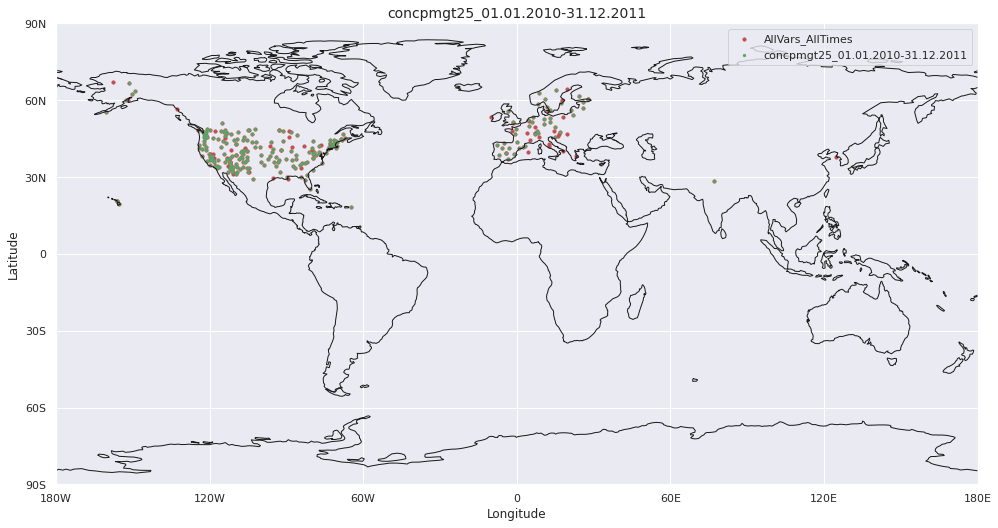

In [8]:
#plotting the coordinates of all the stations
ax = coarse_pm.plot_station_coordinates(markersize=10)
coarse_pm.plot_station_coordinates(markersize=5, var_name='concpmgt25', start=2010, stop=2012, color='g', ax=ax);

In [9]:
# Collecting the data from the chosen stations

phoenix = coarse_pm.to_station_data('Phoenix', vars_to_convert='concpmgt25')
bbnp = coarse_pm.to_station_data('Big Bend National Park-K-Bar (TX04)', vars_to_convert='concpmgt25')
wdc = coarse_pm.to_station_data('Washington D.C.', vars_to_convert='concpmgt25')
anpmh = coarse_pm.to_station_data('Acadia National Park-McFarland Hill (ME98)', vars_to_convert='concpmgt25')

In [10]:
# Collecting the longitude and latitude from each station

placement = {'Phoenix': (phoenix['longitude'], phoenix['latitude']),
            'Big Bend National Park': (bbnp['longitude'], bbnp['latitude']),
            'Washington D.C.': (wdc['longitude'], wdc['latitude']),
            'Acadia National Park-McFarland Hill': (anpmh['longitude'], anpmh['latitude'])}
lonlat = pd.DataFrame(placement).set_index(pd.Index(['longitude', 'latitude']))
lonlat

,Phoenix,Big Bend National Park,Washington D.C.,Acadia National Park-McFarland Hill
longitude,-112.0958,-103.1772,-77.0344,-68.2608
latitude,33.5038,29.3022,38.8762,44.3772


In [11]:
# Slicing the data into the chosen study period

phoenix = phoenix['concpmgt25']['2002-01-01':'2012-01-01']
bbnp = bbnp['concpmgt25']['2002-01-01':'2012-01-01']
wdc = wdc['concpmgt25']['2002-01-01':'2012-01-01']
anpmh = anpmh['concpmgt25']['2002-01-01':'2012-01-01']

In [12]:
data = {'phoenix': phoenix, 'bbnp': bbnp, 'wdc': wdc, 'anpmh': anpmh}
obs_daily = pd.DataFrame(data)
obs_monthly = obs_daily.resample('M').mean()

#Saving the dataframe by running the line below
#obs_monthly.to_pickle('observation_monthly.csv')

### **collecting data from GFDL-ESM4**

In [13]:
#GFDL-ESM4 data in the jupyterhub
path = '/home/4a726423-2d69c2-2d4ee4-2da665-2d1e313c39f43e/'

# GFDL-ESM4 data from 1950-2014
GFDL_pm25_path_f1950 = path + 'shared-new-ns9252k-for-ns1000k/ESGF/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/AERmon/mmrpm2p5/gr1/v20190726/mmrpm2p5_AERmon_GFDL-ESM4_historical_r1i1p1f1_gr1_195001-201412.nc'
GFDL_pm10_path_f1950 = path + 'shared-new-ns9252k-for-ns1000k/ESGF/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/AERmon/mmrpm10/gr1/v20190726/mmrpm10_AERmon_GFDL-ESM4_historical_r1i1p1f1_gr1_195001-201412.nc'

# Open directory using xarray
G_pm25_f1950 = xr.open_mfdataset(GFDL_pm25_path_f1950)
G_pm10_f1950 = xr.open_mfdataset(GFDL_pm10_path_f1950)

In [14]:
#Slice the GFDL-ESM4 data
start = '2002-01-01'
end = '2012-01-01'

G_pm10 = G_pm10_f1950.sel(time=slice(start,end))
G_pm25 = G_pm25_f1950.sel(time=slice(start,end))

In [15]:
#Collecting data from our chosen study sites

#PHOENIX - GFDL-ESM4
level = G_pm10['lev'].values[0] #using the first level, the ax is positive downwards
long1=248                       #collected from the table showing the lonlats for each station
lati1=33.5

G_pm10_phoenix = G_pm10.sel(lon=long1, lat=lati1, method='nearest', lev=level)['mmrpm10'].values
G_pm25_phoenix = G_pm25.sel(lon=long1, lat=lati1, method='nearest', lev=level)['mmrpm2p5'].values

#BIG BEND NATIONAL PARK - GFDL-ESM4
long2=360.0-103.177
lati2=29.3022

G_pm10_bbnp = G_pm10.sel(lon=long2, lat=lati2, method='nearest', lev=level)['mmrpm10'].values
G_pm25_bbnp = G_pm25.sel(lon=long2, lat=lati2, method='nearest', lev=level)['mmrpm2p5'].values

#WASHINGTON D.C. - GFDL-ESM4
long3=360.0-77.0344
lati3=38.8762

G_pm10_wdc = G_pm10.sel(lon=long3, lat=lati3, method='nearest', lev=level)['mmrpm10'].values
G_pm25_wdc = G_pm25.sel(lon=long3, lat=lati3, method='nearest', lev=level)['mmrpm2p5'].values

#ACADIA NATIONAL PARK-MCFARLAND HILL - GFDL-ESM4
long4=360.0-68.2608
lati4=44.3772

G_pm10_anpmh = G_pm10.sel(lon=long4, lat=lati4, method='nearest', lev=level)['mmrpm10'].values
G_pm25_anpmh = G_pm25.sel(lon=long4, lat=lati4, method='nearest', lev=level)['mmrpm2p5'].values

In [16]:
# Extracting the time the measurments were taken
timelist_gfdl=[]
n1 = len(G_pm10.time.values)
for i in range(0, n1):
    timeval = str(G_pm10.time.values[i])
    string = timeval.split()
    timelist_gfdl.append(string[0])

In [17]:
#Gathering the data in to dataframes

#Phoenix
data1 = {'Time': timelist_gfdl, 'PM10 [kg kg-1]': G_pm10_phoenix, 'PM25 [kg kg-1]': G_pm25_phoenix}
phoenix_gfdl = pd.DataFrame(data1)

#Big Bend National Park
data2 = {'Time': timelist_gfdl, 'PM10 [kg kg-1]': G_pm10_bbnp, 'PM25 [kg kg-1]': G_pm25_bbnp}
bbnp_gfdl = pd.DataFrame(data2)

#Washington D.C.
data3 = {'Time': timelist_gfdl, 'PM10 [kg kg-1]': G_pm10_wdc, 'PM25 [kg kg-1]': G_pm25_wdc}
wdc_gfdl = pd.DataFrame(data3)

#Acadia National Park-McFarland Hill
data4 = {'Time': timelist_gfdl, 'PM10 [kg kg-1]': G_pm10_anpmh, 'PM25 [kg kg-1]': G_pm25_anpmh}
anpmh_gfdl = pd.DataFrame(data4)

In [18]:
# multiplying with surface air density = 1.2754 kg/m3
#multiplying with 10^9 to get ug/m3

#Phoenix
mc_pm10 = phoenix_gfdl['PM10 [kg kg-1]']*1.2754*10**9
mc_pm25 = phoenix_gfdl['PM25 [kg kg-1]']*1.2754*10**9
phoenix_mccp = (mc_pm10 - mc_pm25)

#Big Bend National Park
mc_pm10 = bbnp_gfdl['PM10 [kg kg-1]']*1.2754*10**9
mc_pm25 = bbnp_gfdl['PM25 [kg kg-1]']*1.2754*10**9
bbnp_mccp = (mc_pm10 - mc_pm25)

#Washington D.C.
mc_pm10 = wdc_gfdl['PM10 [kg kg-1]']*1.2754*10**9
mc_pm25 = wdc_gfdl['PM25 [kg kg-1]']*1.2754*10**9
wdc_mccp = (mc_pm10 - mc_pm25)

#Acadia National Park-McFarland Hill
mc_pm10 = anpmh_gfdl['PM10 [kg kg-1]']*1.2754*10**9
mc_pm25 = anpmh_gfdl['PM25 [kg kg-1]']*1.2754*10**9
anpmh_mccp = (mc_pm10 - mc_pm25)

data = {'Time': wdc_gfdl['Time'], 'phoenix': phoenix_mccp, 'bbnp': bbnp_mccp, 'wdc': wdc_mccp, 'anpmh': anpmh_mccp}
gfdl_monthly = pd.DataFrame(data)

gfdl_monthly['Datetime'] = pd.to_datetime(gfdl_monthly['Time'])
gfdl_monthly = gfdl_monthly.set_index('Datetime')
gfdl_monthly = gfdl_monthly.drop(['Time'], axis=1)

#Saving the dataframe by running the line below
#gfdl_monthly.to_pickle('gfdl_monthly.csv')

### **collecting data from MIROC6**

In [19]:
#Reading in the data from the jupyterhub
path = '/home/4a726423-2d69c2-2d4ee4-2da665-2d1e313c39f43e/'

#MIROC6 data from 2000 to 2009
M_pm25_path_f2000 = path + 'shared-new-ns9252k-for-ns1000k/ESGF/CMIP6/CMIP/MIROC/MIROC6/historical/r1i1p1f1/AERmon/mmrpm2p5/gn/v20200918/mmrpm2p5_AERmon_MIROC6_historical_r1i1p1f1_gn_200001-200912.nc'
M_pm10_path_f2000 = path + 'shared-new-ns9252k-for-ns1000k/ESGF/CMIP6/CMIP/MIROC/MIROC6/historical/r1i1p1f1/AERmon/mmrpm10/gn/v20200918/mmrpm10_AERmon_MIROC6_historical_r1i1p1f1_gn_200001-200912.nc'

#MIROC6 data from 2010 until 2014
M_pm25_path_u2014 = path + 'shared-new-ns9252k-for-ns1000k/ESGF/CMIP6/CMIP/MIROC/MIROC6/historical/r1i1p1f1/AERmon/mmrpm2p5/gn/v20200918/mmrpm2p5_AERmon_MIROC6_historical_r1i1p1f1_gn_201001-201412.nc'
M_pm10_path_u2014 = path + 'shared-new-ns9252k-for-ns1000k/ESGF/CMIP6/CMIP/MIROC/MIROC6/historical/r1i1p1f1/AERmon/mmrpm10/gn/v20200918/mmrpm10_AERmon_MIROC6_historical_r1i1p1f1_gn_201001-201412.nc'

M_pm25_f2000 = xr.open_mfdataset(M_pm25_path_f2000)
M_pm10_f2000 = xr.open_mfdataset(M_pm10_path_f2000)

M_pm25_u2014 = xr.open_mfdataset(M_pm25_path_u2014)
M_pm10_u2014 = xr.open_mfdataset(M_pm10_path_u2014)

In [20]:
#Slicing the data for the period we want to study
start1 = '2002-01-01'
end1 = '2012-01-01'

start2 = '2010-01-01'
end2 = '2009-12-31'

M_pm10_u2009 = M_pm10_f2000.sel(time=slice(start1,end2))
M_pm25_u2009 = M_pm25_f2000.sel(time=slice(start1,end2))

M_pm10_f2010 = M_pm10_u2014.sel(time=slice(start2,end1))
M_pm25_f2010 = M_pm25_u2014.sel(time=slice(start2,end1))

In [21]:
#Collecting data from our chosen study sites

#Phoenix - MIROC6

level = M_pm10_u2009['lev'].values[0]
long1=248
lati1=33.5

#From 2002 to 2009
M_pm10_u2009_phoenix = M_pm10_u2009.sel(lon=long1, lat=lati1, method='nearest', lev=level)['mmrpm10'].values
M_pm25_u2009_phoenix = M_pm25_u2009.sel(lon=long1, lat=lati1, method='nearest', lev=level)['mmrpm2p5'].values

#From 2010 to 2012
M_pm10_f2010_phoenix = M_pm10_f2010.sel(lon=long1, lat=lati1, method='nearest', lev=level)['mmrpm10'].values
M_pm25_f2010_phoenix = M_pm25_f2010.sel(lon=long1, lat=lati1, method='nearest', lev=level)['mmrpm2p5'].values

# Merging the arrays, obs! losing the date stamp
M_pm10_phoenix = np.concatenate((M_pm10_u2009_phoenix, M_pm10_f2010_phoenix))
M_pm25_phoenix = np.concatenate((M_pm25_u2009_phoenix, M_pm25_f2010_phoenix))


#Big Bend National Park

long2=360.0-103.177
lati2=29.3022

#From 2002 to 2009
M_pm10_u2009_bbnp = M_pm10_u2009.sel(lon=long2, lat=lati2, method='nearest', lev=level)['mmrpm10'].values
M_pm25_u2009_bbnp = M_pm25_u2009.sel(lon=long2, lat=lati2, method='nearest', lev=level)['mmrpm2p5'].values

#From 2010 to 2014
M_pm10_f2010_bbnp = M_pm10_f2010.sel(lon=long2, lat=lati2, method='nearest', lev=level)['mmrpm10'].values
M_pm25_f2010_bbnp = M_pm25_f2010.sel(lon=long2, lat=lati2, method='nearest', lev=level)['mmrpm2p5'].values

# Merging the arrays, obs! losing the date stamp
M_pm10_bbnp = np.concatenate((M_pm10_u2009_bbnp, M_pm10_f2010_bbnp))
M_pm25_bbnp = np.concatenate((M_pm25_u2009_bbnp, M_pm25_f2010_bbnp))


#Washington D.C.

long3=360.0-77.0344
lati3=38.8762

#From 2002 to 2009
M_pm10_u2009_wdc = M_pm10_u2009.sel(lon=long3, lat=lati3, method='nearest', lev=level)['mmrpm10'].values
M_pm25_u2009_wdc = M_pm25_u2009.sel(lon=long3, lat=lati3, method='nearest', lev=level)['mmrpm2p5'].values

#From 2010 to 2014
M_pm10_f2010_wdc = M_pm10_f2010.sel(lon=long3, lat=lati3, method='nearest', lev=level)['mmrpm10'].values
M_pm25_f2010_wdc = M_pm25_f2010.sel(lon=long3, lat=lati3, method='nearest', lev=level)['mmrpm2p5'].values

# Merging the arrays, obs! losing the date stamp
M_pm10_wdc = np.concatenate((M_pm10_u2009_wdc, M_pm10_f2010_wdc))
M_pm25_wdc = np.concatenate((M_pm25_u2009_wdc, M_pm25_f2010_wdc))


#ACADIA NATIONAL PARK-MCFARLAND HILL

long4=360.0-68.2608
lati4=44.3772

#From 2002 to 2009
M_pm10_u2009_anpmh = M_pm10_u2009.sel(lon=long4, lat=lati4, method='nearest', lev=level)['mmrpm10'].values
M_pm25_u2009_anpmh = M_pm25_u2009.sel(lon=long4, lat=lati4, method='nearest', lev=level)['mmrpm2p5'].values

#From 2010 to 2014
M_pm10_f2010_anpmh = M_pm10_f2010.sel(lon=long4, lat=lati4, method='nearest', lev=level)['mmrpm10'].values
M_pm25_f2010_anpmh = M_pm25_f2010.sel(lon=long4, lat=lati4, method='nearest', lev=level)['mmrpm2p5'].values

# Merging the arrays, obs! losing the date stamp
M_pm10_anpmh = np.concatenate((M_pm10_u2009_anpmh, M_pm10_f2010_anpmh))
M_pm25_anpmh = np.concatenate((M_pm25_u2009_anpmh, M_pm25_f2010_anpmh))

In [22]:
# collecting the time the measurments were taken

timelist_miroc1=[]
n2 = len(M_pm10_u2009.time.values)
for i in range(0, n2):
    timeval = str(M_pm10_u2009.time.values[i])
    string = timeval.split('T')
    timelist_miroc1.append(string[0])

timelist_miroc2=[]
n3 = len(M_pm10_f2010.time.values)
for i in range(0,n3):
    timeval = str(M_pm10_f2010.time.values[i])
    string = timeval.split('T')
    timelist_miroc2.append(string[0])
    
timelist_miroc1 = np.array(timelist_miroc1)
timelist_miroc2 = np.array(timelist_miroc2)
timelist_miroc = np.concatenate((timelist_miroc1, timelist_miroc2))

In [23]:
# Gathering the collected data in to dataframes

#Phoenix
data1 = {'Time': timelist_miroc, 'PM10 [kg kg-1]': M_pm10_phoenix, 'PM25 [kg kg-1]': M_pm25_phoenix}
phoenix_miroc = pd.DataFrame(data1)

#Big Bend National Park
data2 = {'Time': timelist_miroc, 'PM10 [kg kg-1]': M_pm10_bbnp, 'PM25 [kg kg-1]': M_pm25_bbnp}
bbnp_miroc = pd.DataFrame(data2)

#Washington D.C.
data3 = {'Time': timelist_miroc, 'PM10 [kg kg-1]': M_pm10_wdc, 'PM25 [kg kg-1]': M_pm25_wdc}
wdc_miroc = pd.DataFrame(data3)

#Acadia National Park-McFarland Hill
data4 = {'Time': timelist_miroc, 'PM10 [kg kg-1]': M_pm10_anpmh, 'PM25 [kg kg-1]': M_pm25_anpmh}
anpmh_miroc = pd.DataFrame(data4)

In [24]:
# multiplying with surface air density = 1.2754 kg/m3
#multiplying with 10^9 to get ug/m3

mc_pm10 = phoenix_miroc['PM10 [kg kg-1]']*1.2754*10**9
mc_pm25 = phoenix_miroc['PM25 [kg kg-1]']*1.2754*10**9
phoenix_mccp = (mc_pm10 - mc_pm25)

mc_pm10 = bbnp_miroc['PM10 [kg kg-1]']*1.2754*10**9
mc_pm25 = bbnp_miroc['PM25 [kg kg-1]']*1.2754*10**9
bbnp_mccp = (mc_pm10 - mc_pm25)

mc_pm10 = wdc_miroc['PM10 [kg kg-1]']*1.2754*10**9
mc_pm25 = wdc_miroc['PM25 [kg kg-1]']*1.2754*10**9
wdc_mccp = (mc_pm10 - mc_pm25)

mc_pm10 = anpmh_miroc['PM10 [kg kg-1]']*1.2754*10**9
mc_pm25 = anpmh_miroc['PM25 [kg kg-1]']*1.2754*10**9
anpmh_mccp = (mc_pm10 - mc_pm25)

In [25]:
#Gathering in one dataframe

data = {'Time': wdc_miroc['Time'], 'phoenix': phoenix_mccp, 'bbnp': bbnp_mccp, 'wdc': wdc_mccp, 'anpmh': anpmh_mccp}
miroc_monthly = pd.DataFrame(data)

miroc_monthly['Datetime'] = pd.to_datetime(miroc_monthly['Time'])
miroc_monthly = miroc_monthly.set_index('Datetime')
miroc_monthly = miroc_monthly.drop(['Time'], axis=1)

#Saving the dataframe by running the line below
#miroc_monthly.to_pickle('miroc_monthly.csv')

## **Sorting data**

In [26]:
#Calculating the yearly mean
obs_yearly =  obs_monthly.resample('Y').mean()
gfdl_yearly = gfdl_monthly.resample('Y').mean()
miroc_yearly = miroc_monthly.resample('Y').mean()

In [38]:
#Calculating the multimonthly average

#phoenix_month = gfdl_mccp['phoenix'].index.strftime('%b')
#for i in len(11):
    
def multimonthly(file):
    mean_val_phoenix = []
    mean_val_bbnp = []
    mean_val_wdc = []
    mean_val_anpmh = []
    for i in range(0,12):
        mean_val_phoenix.append(file['phoenix'][i::12].mean())
        mean_val_bbnp.append(file['bbnp'][i::12].mean())
        mean_val_wdc.append(file['wdc'][i::12].mean())
        mean_val_anpmh.append(file['anpmh'][i::12].mean())

    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    data = {'months': months, 'phoenix': mean_val_phoenix, 'bbnp':  mean_val_bbnp, 'wdc': mean_val_wdc, 'anpmh': mean_val_anpmh}

    df = pd.DataFrame(data)
    df = df.set_index('months')
    
    return df

In [39]:
#Calling the multimonthly function by 
obs_multimonth = multimonthly(obs_monthly)
gfdl_multimonth = multimonthly(gfdl_monthly)
miroc_multimonth = multimonthly(miroc_monthly)

In [43]:
#Calculate the multiyearseasonal average

def multiseason(file):
    file['month'] = file.index.strftime('%b')
    season=[]
    for i in range(len(file['month'])):
        month = file['month'][i]
        if month == 'Jan' or month == 'Feb' or month == 'Dec':
            season.append('D-J-F')
        if month == 'Mar' or month == 'Apr' or month == 'May':
            season.append('M-A-M')
        if month == 'Jun' or month == 'Jul' or month == 'Aug':
            season.append('J-J-A')
        if month == 'Sep' or month == 'Oct' or month == 'Nov':
            season.append('S-O-N')

    file['season']=season
    file = file.drop(['month'], axis=1)
    file_grouped = file[['season','phoenix', 'bbnp', 'wdc', 'anpmh']].groupby('season').mean()
    
    return file_grouped

In [45]:
#calling the function by 

obs_seasonal = multiseason(obs_monthly)
gfdl_seasonal = multiseason(gfdl_monthly)
miroc_seasonal = multiseason(miroc_monthly)

## **Plotting data**

In [29]:
#function for plotting the average concentration

def conc_plot_all(file1, file2, file3, name1, name2, name3, timestep):
    fig, ax = plt.subplots(4,3, figsize=(19,12))
    
    fig.suptitle('{}, {} and {}, {} mean mass concentration'.format(name1, name2, name3, timestep), fontweight='bold')
    
    ax[0,0].plot(file1['phoenix'], '.-', label='phoenix, {}'.format(name1), color='r')
    ax[0,0].legend(loc='best')
    ax[0,0].set(ylabel='mass conc [$\mu$g/m$^3$]')
    
    ax[0,1].plot(file2['phoenix'], '.-', label='phoenix {}'.format(name2),color='b')
    ax[0,1].legend(loc='best')
    ax[0,1].set(ylabel='mass conc [$\mu$g/m$^3$]')
    
    ax[0,2].plot(file3['phoenix'], '.-', label='phoenix {}'.format(name3),color='g')
    ax[0,2].legend(loc='best')
    ax[0,2].set(ylabel='mass conc [$\mu$g/m$^3$]')
    
    ax[1,0].plot(file1['bbnp'], '.-', label='bbnp, {}'.format(name1), color='r')
    ax[1,0].legend(loc='best')
    ax[1,0].set(ylabel='mass conc [$\mu$g/m$^3$]')
    
    ax[1,1].plot(file2['bbnp'], '.-', label='bbnp, {}'.format(name2) ,color='b')
    ax[1,1].legend(loc='best')
    ax[1,1].set(ylabel='mass conc [$\mu$g/m$^3$]')
    
    ax[1,2].plot(file3['bbnp'], '.-', label='bbnp, {}'.format(name3) ,color='g')
    ax[1,2].legend(loc='best')
    ax[1,2].set(ylabel='mass conc [$\mu$g/m$^3$]')
    
    ax[2,0].plot(file1['wdc'], '.-', label='wdc, {}'.format(name1), color='r')
    ax[2,0].legend(loc='best')
    ax[2,0].set(ylabel='mass conc [$\mu$g/m$^3$]')
    
    ax[2,1].plot(file2['wdc'], '.-', label='wdc, {}'.format(name2), color='b')
    ax[2,1].legend(loc='best')
    ax[2,1].set(ylabel='mass conc [$\mu$g/m$^3$]')
    
    ax[2,2].plot(file3['wdc'], '.-', label='wdc, {}'.format(name3), color='g')
    ax[2,2].legend(loc='best')
    ax[2,2].set(ylabel='mass conc [$\mu$g/m$^3$]')
    
    ax[3,0].plot(file1['anpmh'], '.-', label='anpmh, {}'.format(name1),color='r')
    ax[3,0].legend(loc='best')
    ax[3,0].set(ylabel='mass conc [$\mu$g/m$^3$]')

    ax[3,1].plot(file2['anpmh'], '.-', label='anpmh, {}'.format(name2), color='b')
    ax[3,1].legend(loc='best')
    ax[3,1].set(ylabel='mass conc [$\mu$g/m$^3$]')
    
    ax[3,2].plot(file3['anpmh'], '.-', label='anpmh, {}'.format(name3), color='g')
    ax[3,2].legend(loc='best')
    ax[3,2].set(ylabel='mass conc [$\mu$g/m$^3$]')
    
    plt.figtext(0.5,0,'{} mass concentration of {} (left), {} (centre) and {} (right)'.format(timestep,name1,name2,name3), ha='center')
    
    #plt.savefig('{}_obs_{}_{}.png'.format(timestep, name2,name3))

In [47]:
# call function by

# monthly average:
#conc_plot_all(obs_monthly, gfdl_monthly, miroc_monthly, 'obs', 'GFDL-ESM4', 'MIROC6', 'monthly')

# yearly average:
#conc_plot_all(obs_yearly, gfdl_yearly, miroc_yearly, 'obs', 'GFDL-ESM4', 'MIROC6', 'yearly')

#yearly average for each separate month:
#conc_plot_all(obs_multimonth, gfdl_multimonth, miroc_multimonth, 'obs', 'GFDL-ESM4', 'MIROC6', 'multimonthly')

#yearly average for each separate season:
#conc_plot_all(obs_seasonal, gfdl_seasonal, miroc_seasonal, 'obs', 'GFDL-ESM4', 'MIROC6', 'multiseasonal')

In [30]:
def scatter_main(obs, file, name, savedas, timestep):
    fig, axs = plt.subplots(2, 2, figsize=(12,12))
    fig.suptitle('Observations ~ {}'.format(name), fontweight='bold')
    
    correlation1, p_value1 = st.pearsonr(obs['phoenix'], file['phoenix'])
    axs[0,0].scatter(obs['phoenix'], file['phoenix'], alpha=0.6)
    axs[0,0].set(xlabel='observation, mass conc [$\mu$g/m$^3$]',
                ylabel='{}, mass conc[$\mu$g/m$^3$]'.format(name))
    axs[0,0].set_title('Phoenix, pearson corr = {:.4f}'.format(correlation1))
    
    correlation2, p_value2 = st.pearsonr(obs['bbnp'], file['bbnp'])
    axs[0,1].scatter(obs['bbnp'], file['bbnp'], alpha=0.6, color='darkorange')
    axs[0,1].set(xlabel='observation, mass conc [$\mu$g/m$^3$]',
                ylabel='{}, mass conc[$\mu$g/m$^3$]'.format(name))
    axs[0,1].set_title('Big Bend National Park, pearson corr = {:.4f}'.format(correlation2))
    
    nans_to_zero = obs['wdc'].fillna(0) #observation data for Washington D.C. contains NaNs, change to zero
    correlation3, p_value3 = st.pearsonr(nans_to_zero, file['wdc'])
    axs[1,0].scatter(obs['wdc'], file['wdc'], alpha=0.6, color='g')
    axs[1,0].set(xlabel='observation, mass conc [$\mu$g/m$^3$]',
                ylabel='{}, mass conc[$\mu$g/m$^3$]'.format(name))
    axs[1,0].set_title('Washington D.C., pearson corr = {:.4f}'.format(correlation3))
    
    correlation4, p_value4 = st.pearsonr(obs['anpmh'], file['anpmh'])
    axs[1,1].scatter(obs['anpmh'], file['anpmh'],alpha=0.6, color='r')
    axs[1,1].set(xlabel='observation, mass conc [$\mu$g/m$^3$]',
                ylabel='{}, mass conc[$\mu$g/m$^3$]'.format(name))
    axs[1,1].set_title('Acadia National Park - McFarland Hill, pearson corr = {:.4f}'.format(correlation4))
    
    plt.figtext(0.5,0, 'The scatterplot and correlation of the {} concentration between observation\n\
    and {} for each station; Phoenix, Big Bend National Park, Washington D.C. and Acadia NP-McFarland Hill'.format(timestep, name),
                ha='center');
    #plt.savefig('{}.png'.format(savedas))

In [56]:
# plotting the distribution of the multiyear average for each month
# To plot this, I had to locate which month the measurment was taken for each site
# Use the melt function to sort the data in preperation for plotting
obs_phoenix = pd.DataFrame(obs_monthly['phoenix'])
obs_phoenix['month'] = obs_phoenix.index.strftime('%b')
obs_bbnp = pd.DataFrame(obs_monthly['bbnp'])
obs_bbnp['month'] = obs_bbnp.index.strftime('%b')
obs_wdc = pd.DataFrame(obs_monthly['wdc'])
obs_wdc['month'] = obs_wdc.index.strftime('%b')
obs_anpmh = pd.DataFrame(obs_monthly['anpmh'])
obs_anpmh['month'] = obs_anpmh.index.strftime('%b')

gfdl_phoenix = pd.DataFrame(gfdl_monthly['phoenix'])
gfdl_phoenix['month'] = gfdl_phoenix.index.strftime('%b')
gfdl_bbnp = pd.DataFrame(gfdl_monthly['bbnp'])
gfdl_bbnp['month'] = gfdl_bbnp.index.strftime('%b')
gfdl_wdc = pd.DataFrame(gfdl_monthly['wdc'])
gfdl_wdc['month'] = gfdl_wdc.index.strftime('%b')
gfdl_anpmh = pd.DataFrame(gfdl_monthly['anpmh'])
gfdl_anpmh['month'] = gfdl_anpmh.index.strftime('%b')

miroc_phoenix = pd.DataFrame(miroc_monthly['phoenix'])
miroc_phoenix['month'] = miroc_phoenix.index.strftime('%b')
miroc_bbnp = pd.DataFrame(miroc_monthly['bbnp'])
miroc_bbnp['month'] = miroc_bbnp.index.strftime('%b')
miroc_wdc = pd.DataFrame(miroc_monthly['wdc'])
miroc_wdc['month'] = miroc_wdc.index.strftime('%b')
miroc_anpmh = pd.DataFrame(miroc_monthly['anpmh'])
miroc_anpmh['month'] = miroc_anpmh.index.strftime('%b')

obs_phoenix_melted = pd.melt(obs_phoenix, id_vars=['month'], var_name='station')
obs_bbnp_melted = pd.melt(obs_bbnp, id_vars=['month'], var_name='station')
obs_wdc_melted = pd.melt(obs_wdc, id_vars=['month'], var_name='station')
obs_anpmh_melted = pd.melt(obs_anpmh, id_vars=['month'], var_name='station')

gfdl_phoenix_melted = pd.melt(gfdl_phoenix, id_vars=['month'], var_name='station')
gfdl_bbnp_melted = pd.melt(gfdl_bbnp, id_vars=['month'], var_name='station')
gfdl_wdc_melted = pd.melt(gfdl_wdc, id_vars=['month'], var_name='station')
gfdl_anpmh_melted = pd.melt(gfdl_anpmh, id_vars=['month'], var_name='station')

miroc_phoenix_melted = pd.melt(miroc_phoenix, id_vars=['month'], var_name='station')
miroc_bbnp_melted = pd.melt(miroc_bbnp, id_vars=['month'], var_name='station')
miroc_wdc_melted = pd.melt(miroc_wdc, id_vars=['month'], var_name='station')
miroc_anpmh_melted = pd.melt(miroc_anpmh, id_vars=['month'], var_name='station')


In [ ]:
# plotting 
flierprops = dict(markersize=1.5) #decides the markersize of any outliers in the plot
fig, ax = plt.subplots(4,3, figsize=(17,25))
fig.suptitle('Distribution of multimonthly average', fontweight='bold')
sns.boxplot(x='month',y='value',data=obs_phoenix_melted, 
            linewidth=0.5, flierprops=flierprops,color='r', ax=ax[0,0])
ax[0,0].set(ylabel='mass concentration [$\mu$g/m$^3$]',xlabel='')
ax[0,0].set_title('Phoenix - Observations')
sns.boxplot(x='month',y='value',data=obs_bbnp_melted, 
            linewidth=0.5, flierprops=flierprops,color='r', ax=ax[1,0])
ax[1,0].set(ylabel='mass concentration [$\mu$g/m$^3$]',xlabel='')
ax[1,0].set_title('Big Bend NP - Observations')
sns.boxplot(x='month',y='value',data=obs_wdc_melted, 
            linewidth=0.5, flierprops=flierprops,color='r', ax=ax[2,0])
ax[2,0].set(ylabel='mass concentration [$\mu$g/m$^3$]',xlabel='')
ax[2,0].set_title('Washington D.C. - Observations')
sns.boxplot(x='month',y='value',data=obs_anpmh_melted, 
            linewidth=0.5, flierprops=flierprops,color='r', ax=ax[3,0])
ax[3,0].set(ylabel='mass concentration [$\mu$g/m$^3$]',xlabel='')
ax[3,0].set_title('Acadia NP-McFarland Hill - Observations')

sns.boxplot(x='month',y='value',data=gfdl_phoenix_melted, 
            linewidth=0.5, flierprops=flierprops,color='b', ax=ax[0,1])
ax[0,1].set(ylabel='mass concentration [$\mu$g/m$^3$]',xlabel='')
ax[0,1].set_title('Phoenix - GFDL-ESM4')
sns.boxplot(x='month',y='value',data=gfdl_bbnp_melted, 
            linewidth=0.5, flierprops=flierprops,color='b', ax=ax[1,1])
ax[1,1].set(ylabel='mass concentration [$\mu$g/m$^3$]',xlabel='')
ax[1,1].set_title('Big Bend NP - GFDL-ESM4')
sns.boxplot(x='month',y='value',data=gfdl_wdc_melted, 
            linewidth=0.5, flierprops=flierprops,color='b', ax=ax[2,1])
ax[2,1].set(ylabel='mass concentration [$\mu$g/m$^{3}$]',xlabel='')
ax[2,1].set_title('Washington D.C. - GFDL-ESM4')
sns.boxplot(x='month',y='value',data=gfdl_anpmh_melted, 
            linewidth=0.5, flierprops=flierprops,color='b', ax=ax[3,1])
ax[3,1].set(ylabel='mass concentration [$\mu$g/m$^{3}$]',xlabel='')
ax[3,1].set_title('Acadia NP-McFarland Hill - GFDL-ESM4')

sns.boxplot(x='month',y='value',data=miroc_phoenix_melted, 
            linewidth=0.5, flierprops=flierprops,color='g', ax=ax[0,2])
ax[0,2].set(ylabel='mass concentration [$\mu$g/m$^{3}$]',xlabel='')
ax[0,2].set_title('Phoenix - MIROC6')
sns.boxplot(x='month',y='value',data=miroc_bbnp_melted, 
            linewidth=0.5, flierprops=flierprops,color='g', ax=ax[1,2])
ax[1,2].set(ylabel='mass concentration [$\mu$g/m$^{3}$]',xlabel='')
ax[1,2].set_title('Big Bend NP - MIROC6')
sns.boxplot(x='month',y='value',data=miroc_wdc_melted, 
            linewidth=0.5, flierprops=flierprops,color='g', ax=ax[2,2])
ax[2,2].set(ylabel='mass concentration [$\mu$g/m$^{3}$]',xlabel='')
ax[2,2].set_title('Washington D.C. - MIROC6')
sns.boxplot(x='month',y='value',data=miroc_anpmh_melted, 
            linewidth=0.5, flierprops=flierprops,color='g', ax=ax[3,2])
ax[3,2].set(ylabel='mass concentration [$\mu$g/m$^{3}$]',xlabel='')
ax[3,2].set_title('Acadia NP-McFarland Hill - MIROC6')

plt.figtext(0.5,0, 'The distribution of the multimonthly average for the observations (left), GFDL-ESM4 (center) and MIROC6 (right)\n\
for each station; Phoenix, Big Bend National Park, Washington D.C. and Acadia National Park-McFarland Hill', ha='center');
#plt.savefig('multi_monthly.png')

In [57]:
# using the melt function in preparation for plotting
def season_melt(file):
    season=[]
    for i in range(len(file['month'])):
        month = file['month'][i]
        if month == 'Jan' or month == 'Feb' or month == 'Dec':
            season.append('D-J-F')
        if month == 'Mar' or month == 'Apr' or month == 'May':
            season.append('M-A-M')
        if month == 'Jun' or month == 'Jul' or month == 'Aug':
            season.append('J-J-A')
        if month == 'Sep' or month == 'Oct' or month == 'Nov':
            season.append('S-O-N')

    file['season']=season
    file = file.drop(['month'], axis=1)
    
    melted = pd.melt(file, id_vars=['season'], var_name='station')
    return melted

In [58]:
obs_phoenix_season, obs_bbnp_season, obs_wdc_season, obs_anpmh_season = season_melt(obs_phoenix), season_melt(obs_bbnp),\
                                                                        season_melt(obs_wdc), season_melt(obs_anpmh)
gfdl_phoenix_season, gfdl_bbnp_season, gfdl_wdc_season, gfdl_anpmh_season = season_melt(gfdl_phoenix), season_melt(gfdl_bbnp),\
                                                                        season_melt(gfdl_wdc), season_melt(gfdl_anpmh)
miroc_phoenix_season, miroc_bbnp_season, miroc_wdc_season, miroc_anpmh_season = season_melt(miroc_phoenix), season_melt(miroc_bbnp),\
                                                                        season_melt(miroc_wdc), season_melt(miroc_anpmh)

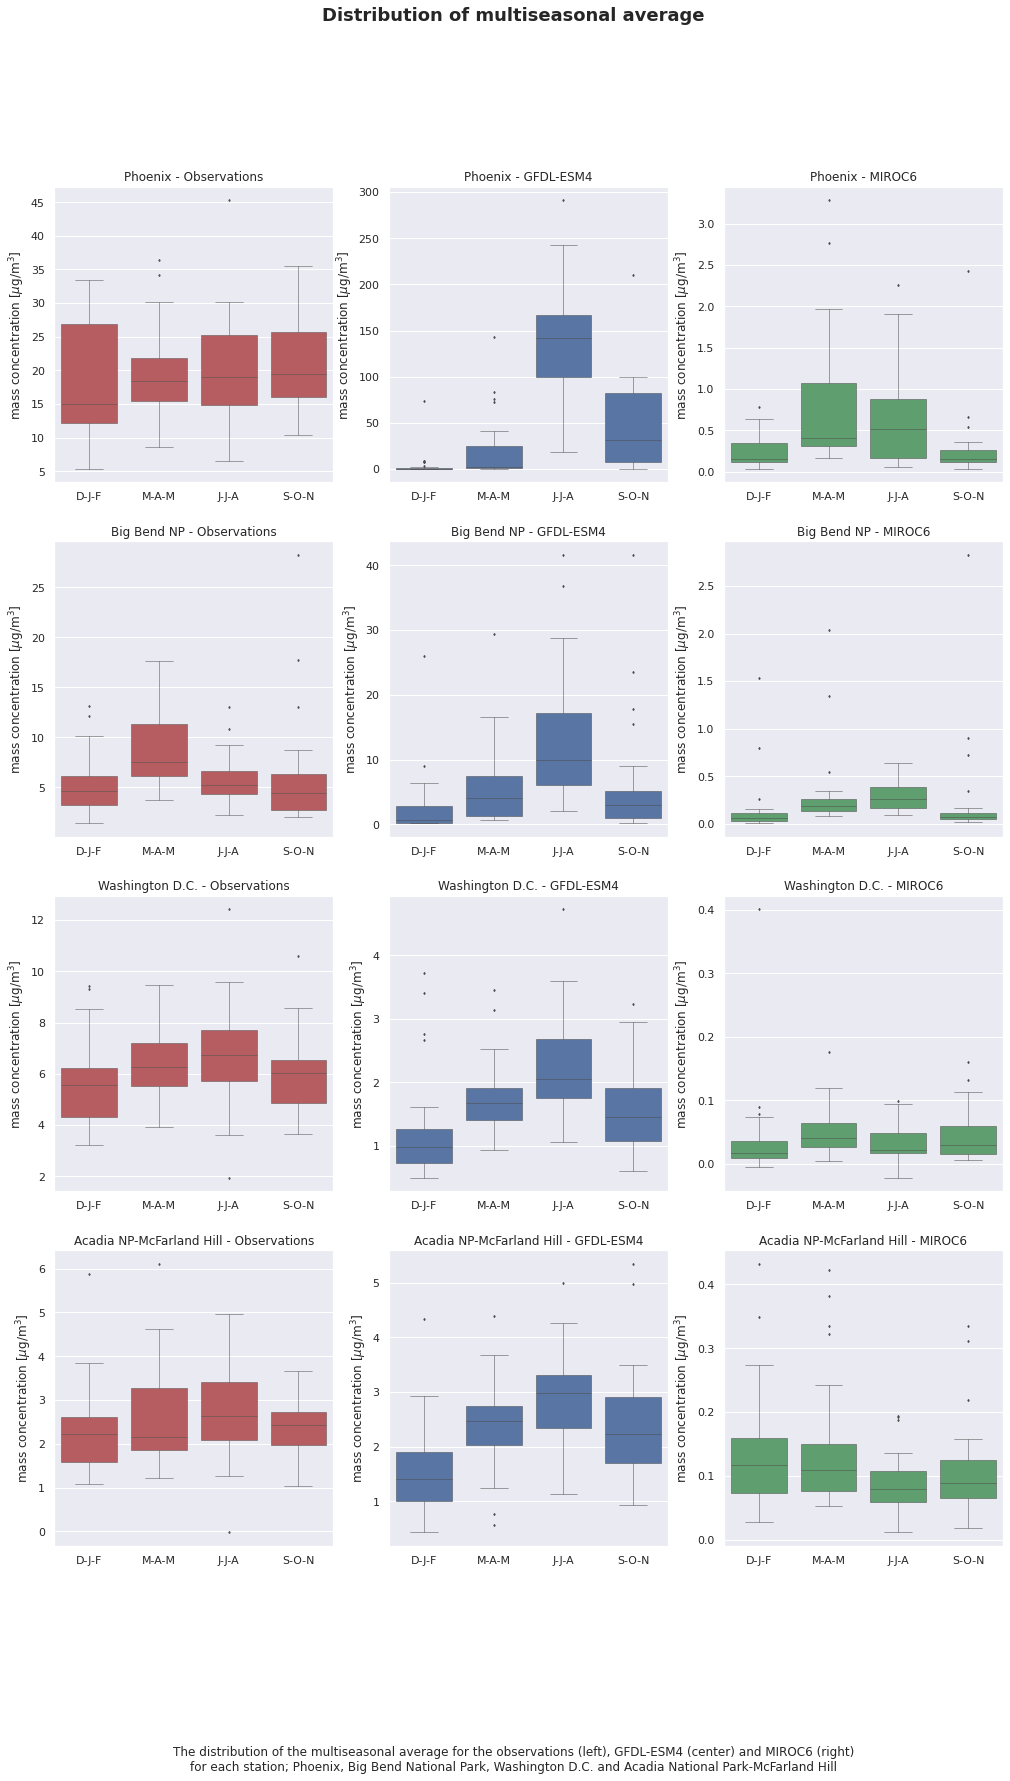

In [59]:
# plotting the multiyear average for each season
flierprops = dict(markersize=1.5) 
fig, ax = plt.subplots(4,3, figsize=(17,25))
fig.suptitle('Distribution of multiseasonal average', fontweight='bold')
sns.boxplot(x='season',y='value',data=obs_phoenix_season, 
            linewidth=0.5, flierprops=flierprops,color='r', ax=ax[0,0])
ax[0,0].set(ylabel='mass concentration [$\mu$g/m$^3$]',xlabel='')
ax[0,0].set_title('Phoenix - Observations')
sns.boxplot(x='season',y='value',data=obs_bbnp_season, 
            linewidth=0.5, flierprops=flierprops,color='r', ax=ax[1,0])
ax[1,0].set(ylabel='mass concentration [$\mu$g/m$^3$]',xlabel='')
ax[1,0].set_title('Big Bend NP - Observations')
sns.boxplot(x='season',y='value',data=obs_wdc_season, 
            linewidth=0.5, flierprops=flierprops,color='r', ax=ax[2,0])
ax[2,0].set(ylabel='mass concentration [$\mu$g/m$^3$]',xlabel='')
ax[2,0].set_title('Washington D.C. - Observations')
sns.boxplot(x='season',y='value',data=obs_anpmh_season, 
            linewidth=0.5, flierprops=flierprops,color='r', ax=ax[3,0])
ax[3,0].set(ylabel='mass concentration [$\mu$g/m$^3$]',xlabel='')
ax[3,0].set_title('Acadia NP-McFarland Hill - Observations')

sns.boxplot(x='season',y='value',data=gfdl_phoenix_season, 
            linewidth=0.5, flierprops=flierprops,color='b', ax=ax[0,1])
ax[0,1].set(ylabel='mass concentration [$\mu$g/m$^3$]',xlabel='')
ax[0,1].set_title('Phoenix - GFDL-ESM4')
sns.boxplot(x='season',y='value',data=gfdl_bbnp_season, 
            linewidth=0.5, flierprops=flierprops,color='b', ax=ax[1,1])
ax[1,1].set(ylabel='mass concentration [$\mu$g/m$^3$]',xlabel='')
ax[1,1].set_title('Big Bend NP - GFDL-ESM4')
sns.boxplot(x='season',y='value',data=gfdl_wdc_season, 
            linewidth=0.5, flierprops=flierprops,color='b', ax=ax[2,1])
ax[2,1].set(ylabel='mass concentration [$\mu$g/m$^{3}$]',xlabel='')
ax[2,1].set_title('Washington D.C. - GFDL-ESM4')
sns.boxplot(x='season',y='value',data=gfdl_anpmh_season, 
            linewidth=0.5, flierprops=flierprops,color='b', ax=ax[3,1])
ax[3,1].set(ylabel='mass concentration [$\mu$g/m$^{3}$]',xlabel='')
ax[3,1].set_title('Acadia NP-McFarland Hill - GFDL-ESM4')

sns.boxplot(x='season',y='value',data=miroc_phoenix_season, 
            linewidth=0.5, flierprops=flierprops,color='g', ax=ax[0,2])
ax[0,2].set(ylabel='mass concentration [$\mu$g/m$^{3}$]',xlabel='')
ax[0,2].set_title('Phoenix - MIROC6')
sns.boxplot(x='season',y='value',data=miroc_bbnp_season, 
            linewidth=0.5, flierprops=flierprops,color='g', ax=ax[1,2])
ax[1,2].set(ylabel='mass concentration [$\mu$g/m$^{3}$]',xlabel='')
ax[1,2].set_title('Big Bend NP - MIROC6')
sns.boxplot(x='season',y='value',data=miroc_wdc_season, 
            linewidth=0.5, flierprops=flierprops,color='g', ax=ax[2,2])
ax[2,2].set(ylabel='mass concentration [$\mu$g/m$^{3}$]',xlabel='')
ax[2,2].set_title('Washington D.C. - MIROC6')
sns.boxplot(x='season',y='value',data=miroc_anpmh_season, 
            linewidth=0.5, flierprops=flierprops,color='g', ax=ax[3,2])
ax[3,2].set(ylabel='mass concentration [$\mu$g/m$^{3}$]',xlabel='')
ax[3,2].set_title('Acadia NP-McFarland Hill - MIROC6')

plt.figtext(0.5,0, 'The distribution of the multiseasonal average for the observations (left), GFDL-ESM4 (center) and MIROC6 (right)\n\
for each station; Phoenix, Big Bend National Park, Washington D.C. and Acadia National Park-McFarland Hill', ha='center');
#plt.savefig('multi_seasonal.png')